ноутбук в колаб: https://colab.research.google.com/drive/1ceJwncr_WqKxYo_isx5Lsvz2H4ynt56-?usp=sharing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Повторение

## Загрузка и подготовка данных

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/datasets_14872_228180_Admission_Predict_Ver1.1.csv')
del df['Serial No.']

In [ ]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
# мало :(
len(df)

500

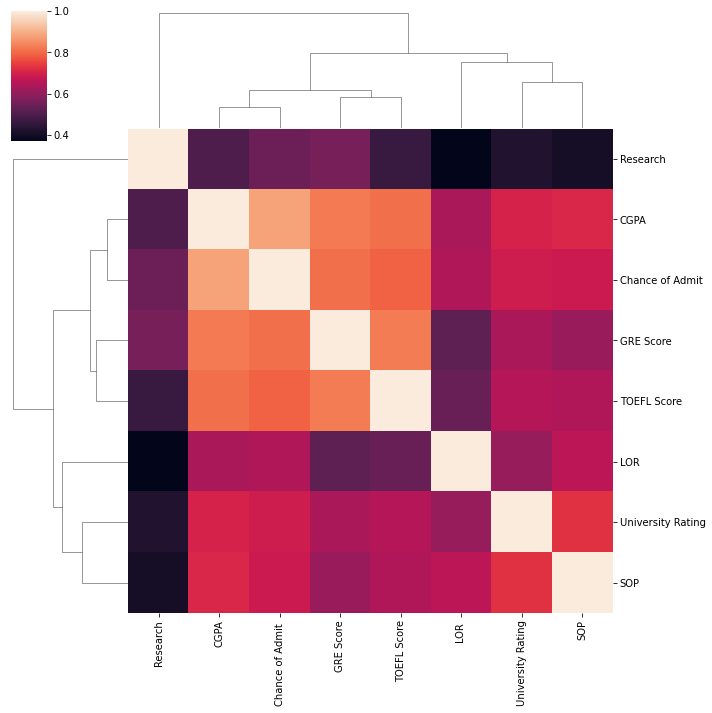

In [ ]:
import seaborn as sns

sns.clustermap(df.corr())

In [ ]:
# перемешка
df = df.sample(frac=1).reset_index(drop=True)
# train test split
df_train = df[:400]
df_test = df[400:]
# среднее и стандартное отклонение
mean = df.mean(axis=0)
std = df.std(axis=0)
# 0 мат ожидание и 1 дисперсию
df_train = (df_train - mean)/std
X_train = df_train.drop(columns=['Chance of Admit ']).values
y_train = df_train['Chance of Admit '].values
df_test = (df_test - mean)/std
X_test = df_test.drop(columns=['Chance of Admit ']).values
y_test = df_test['Chance of Admit '].values

In [ ]:
X_train[:5]

array([[-0.75005655, -1.01810831, -0.97419196, -0.37739519,  0.55756685,
        -1.11842871, -1.12702343],
       [ 0.84354802,  0.95496981,  1.64930524,  1.13622188,  0.55756685,
         1.36167753,  0.88551841],
       [ 0.40088008,  0.2972771 , -0.09969289, -0.37739519,  0.55756685,
        -0.62240746,  0.88551841],
       [-0.04178785, -0.85368513, -0.09969289, -1.38647324, -0.52298906,
        -1.94513079, -1.12702343],
       [-1.28125807, -0.85368513, -0.09969289,  0.12714383,  1.63812275,
        -0.40746492, -1.12702343]])

In [ ]:
y_train[:5]

array([-0.29573389,  1.33384909,  0.20022615, -0.57913962, -0.50828819])

## Создание алгоритма

In [ ]:
print('размерность пространства признаков:', X_train.shape[1])
# инициализация весов под размерность пространства признаков
w = np.ones(X_train.shape[1])
# выбираем случайный индекс, по которому найдем частную производную
ind = np.random.randint(X_train.shape[1])
print('Случайный индекс', ind)
# переможим выбранный столбец на нужный вес (получаем кол-во элементов train)
len(np.dot(X_train[:,ind], w[ind]))

размерность пространства признаков: 7
Случайный индекс 2


400

$$MSE = \frac{1}{n}\sum_{i = 1}^{n}(y_i - \hat{y_i})^2$$

Реализуем ошибку по формуле:

In [ ]:
mse = lambda y, y_pred:((y-y_pred)**2).sum()/len(y_pred)   

In [ ]:
# очистка экрана
from google.colab import output
# коэффициент детерминации
from sklearn.metrics import r2_score

Стохастический градиентный спуск (англ. stochastic gradient descent, SGD) − оптимизационный алгоритм, отличающийся от обычного градиентного спуска тем, что градиент оптимизируемой функции считается на каждом шаге не как сумма градиентов от каждого элемента выборки, а как градиент от одного, случайно выбранного элемента.

![dssmall](https://github.com/m9psy/neural_network_habr_guide/blob/master/Part%203/images/stochastic.gif?raw=true)

$$w_{t+1} = w_{t} - \frac{2\alpha}{n}X_i(<X_i, w_{t}> - y_i) $$

Реализуем шаг по формуле

In [ ]:
gradient_step_stah = lambda X, y, w, alpha, ind: w - (alpha* 2.0 / X.shape[0]) * X[ind] * (np.dot(X[ind], w) - y[ind])

In [ ]:
# выбрали случайный индекс
ind = np.random.randint(X_train.shape[1])
# сделали один шаг (w = [1, 1, ...])
gradient_step_stah(X_train, y_train, np.ones(X_train.shape[1]),1e-4,ind)

array([0.99999976, 0.99999978, 0.99999994, 0.99999915, 0.99999968,
       0.99999943, 1.00000054])

In [ ]:
X_train.shape[1]

7

## Обучение алгоритма

In [ ]:
# стохастический градиентный спуск
def sgd(X, y, w, alpha = 1e-4, max_it = 10e6):
    # номер итерации
    iter_num = 0
    # ошибки на трейне
    errors = []
    # ошибки на тесте
    errors_test = []
    # r2 на тесте
    r2 = []
    while (iter_num < max_it):
        # выбираем случайный элемент
        ind = np.random.randint(X.shape[0])
        # обновляем веса град спуском
        w = gradient_step_stah(X, y, w, alpha, ind)
        # отображаем каждый %
        if iter_num%(int(max_it/100))==0:
            # очищаем экран
            output.clear()
            print('Выполнено:', int(iter_num/max_it * 100), '%')
            # mse train
            error = mse(y_train,np.dot(X_train, w))
            errors.append(error)
            print('Mse train:', error)
            # mse test
            error = mse(y_test,np.dot(X_test, w))
            errors_test.append(error)
            print('Mse test:', error)
            # r2 test
            R = r2_score(y_test,np.dot(X_test, w))
            r2.append(R)
            print('R2:', R)
        iter_num += 1

    return w, errors, errors_test, r2

w, mse_train, mse_test, r2 = sgd(X_train, y_train, np.ones(X_train.shape[1]))

Выполнено: 99 %
Mse train: 0.1979148108331011
Mse test: 0.12146346162909519
R2: 0.8444109054597653


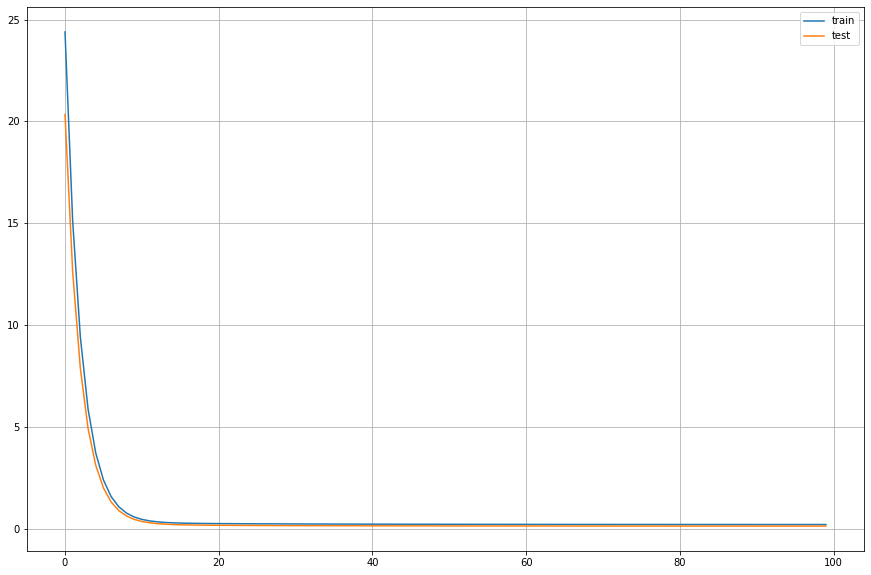

In [ ]:
from matplotlib.pyplot import figure

plt.figure(figsize=(15,10))
plt.grid()

plt.plot(mse_train, label = 'train')
plt.plot(mse_test, label = 'test')
plt.legend()

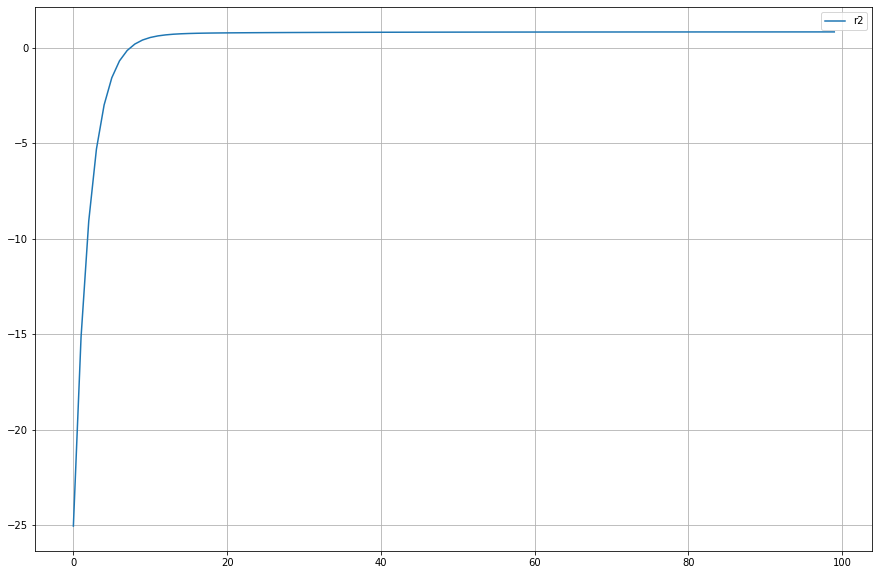

In [ ]:
from matplotlib.pyplot import figure

plt.figure(figsize=(15,10))
plt.grid()

plt.plot(r2, label = 'r2')
plt.legend()

In [ ]:
print('веса', w)
print('R^2 = ', r2_score(y_test, np.dot(X_test,w)))

веса [0.19854855 0.16123524 0.06034153 0.03323349 0.13712037 0.35897761
 0.10055719]
R^2 =  0.8444942023608428


In [ ]:
# массив результатов
r2_shuffles = []
# проверим, зависит ли изначальная перемешка от результата
for i in range(20):
    print(f'Итерация {i+1}')
    # перемешка
    df = df.sample(frac=1).reset_index(drop=True)
    # train test split
    df_train = df[:400]
    df_test = df[400:]
    # среднее и стандартное отклонение
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    # 0 мат ожидание и 1 дисперсию
    df_train = (df_train - mean)/std
    X_train = df_train.drop(columns=['Chance of Admit ']).values
    y_train = df_train['Chance of Admit '].values
    df_test = (df_test - mean)/std
    X_test = df_test.drop(columns=['Chance of Admit ']).values
    y_test = df_test['Chance of Admit '].values

    w, mse_train, mse_test, r2 = sgd(X_train, y_train, np.ones(X_train.shape[1]))
    print(f'Итерация {i+1} | R^2 = ', r2_score(y_test, np.dot(X_test,w)))
    r2_shuffles.append(r2_score(y_test, np.dot(X_test,w)))

Выполнено: 53 %
Mse train: 0.19051628269195425
Mse test: 0.22203256156963938
R2: 0.7824011661766636


KeyboardInterrupt: ignored

{'boxes': [<matplotlib.lines.Line2D at 0x7f5c45e43ac8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5c45e52588>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5c45ddb048>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5c45e52c88>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5c45e43e48>,
  <matplotlib.lines.Line2D at 0x7f5c45e52208>]}

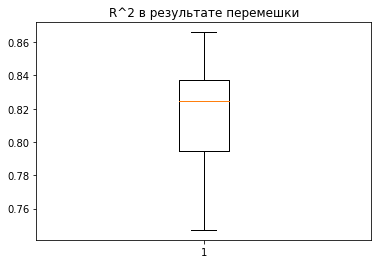

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('R^2 в результате перемешки')
ax1.boxplot(r2_shuffles)

Вывод: сильно зависит от перемешки -> данные нерепрезентативны -> накапливаем еще или аугментируем

## Обучение с помощью sklearn

In [ ]:
from sklearn.linear_model import SGDRegressor
# инициализируем и обучаем
reg = SGDRegressor()
reg.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
print('Mse sgd (sklearn): ', r2_score(y_test, reg.predict(X_test)))

Mse sgd (sklearn):  0.8099229508452628


Настраиваем тонко

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {'penalty': ['l1', 'l2'],
        'alpha': [1e-4, 1e-5, 1e-6, 1e-7]}

reg = SGDRegressor()
gs = GridSearchCV(reg, grid, cv=5)

# Обучаем его
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'alpha': 0.0001, 'penalty': 'l2'}, 0.8097119654612956)

In [ ]:
from sklearn.linear_model import SGDRegressor
# инициализируем и обучаем
reg = SGDRegressor(alpha = 1e-05, penalty = 'l2')
reg.fit(X_train, y_train)

SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
print('Mse sgd (sklearn): ', r2_score(y_test, reg.predict(X_test)))

Mse sgd (sklearn):  0.8085748782624143


In [ ]:
fin_score = []

for i in range(30):
    print(f'Итерация {i+1}')
    # перемешка
    df = df.sample(frac=1).reset_index(drop=True)
    # train test split
    df_train = df[:400]
    df_test = df[400:]
    # среднее и стандартное отклонение
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    # 0 мат ожидание и 1 дисперсию
    df_train = (df_train - mean)/std
    X_train = df_train.drop(columns=['Chance of Admit ']).values
    y_train = df_train['Chance of Admit '].values
    df_test = (df_test - mean)/std
    X_test = df_test.drop(columns=['Chance of Admit ']).values
    y_test = df_test['Chance of Admit '].values

    # обучение
    grid = {'penalty': ['l1', 'l2'],
            'alpha': [1e-4, 1e-5, 1e-6, 1e-7]}

    reg = SGDRegressor()
    gs = GridSearchCV(reg, grid, cv=5, scoring = 'r2')

    # Обучаем его
    gs.fit(X_train, y_train)
    print(gs.best_score_)
    fin_score.append(gs.best_score_)

Итерация 1
0.8109177706435201
Итерация 2
0.8198261986327733
Итерация 3
0.8092944066597569
Итерация 4
0.8078472515506094
Итерация 5
0.8119252273501584
Итерация 6
0.7969072937292928
Итерация 7
0.7956026082377654
Итерация 8
0.8036936558068124
Итерация 9
0.8060383820051505
Итерация 10
0.8032334665712701
Итерация 11
0.8063744122411365
Итерация 12
0.814178695781138
Итерация 13
0.8113545721445821
Итерация 14
0.8000055833354516
Итерация 15
0.7936631228843594
Итерация 16
0.8128613722777185
Итерация 17
0.8174970129769239
Итерация 18
0.7978412281418048
Итерация 19
0.8081217313303494
Итерация 20
0.8204904791626919
Итерация 21
0.8159335375063641
Итерация 22
0.8187848150067663
Итерация 23
0.8072786430431321
Итерация 24
0.8033467813126485
Итерация 25
0.8249546871718272
Итерация 26
0.8244556550113333
Итерация 27
0.8117539794599405
Итерация 28
0.7904734177162176
Итерация 29
0.8014776460898485
Итерация 30
0.8105552181734911


{'boxes': [<matplotlib.lines.Line2D at 0x7f5c4440f518>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5c4440ff28>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5c443989e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5c44398668>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5c4440f828>,
  <matplotlib.lines.Line2D at 0x7f5c4440fba8>]}

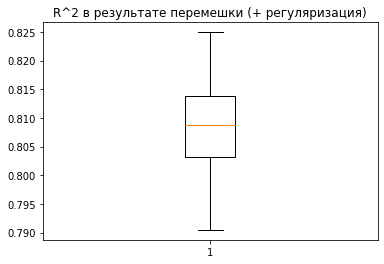

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('R^2 в результате перемешки (+ регуляризация)')
ax1.boxplot(fin_score)

# Работа с линейными методами

На основе https://www.kaggle.com/zynicide/wine-reviews#winemag-data_first150k.csv

In [ ]:
# импортируем зависимости
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/winemag-data-130k-v2.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Корректно ли все загрузилось, сколько пропусков?

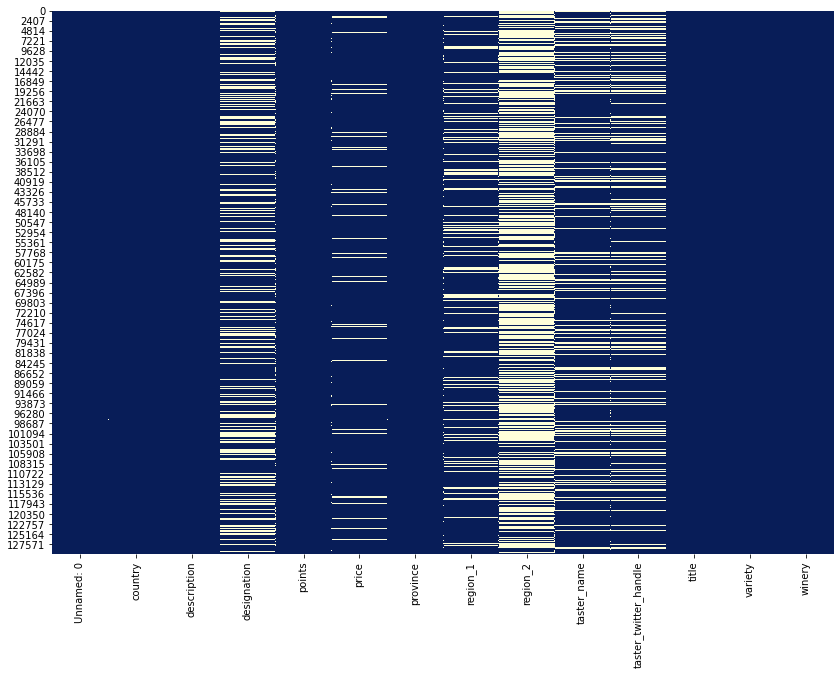

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

Нам важно, чтоб был столбец цены. Столбцы region_2 (2й регион), taster_name (имя тестировщика), taster_twitter_handle (твиттер тестировщика), designation (назначение) нам не особо важны. Остальные стобцы почистим

In [ ]:
df.drop(columns=['region_2', 'Unnamed: 0', 'taster_name', 'taster_twitter_handle', 'designation'], inplace=True)
df.dropna(inplace=True)
df.head()

,country,description,points,price,province,region_1,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo


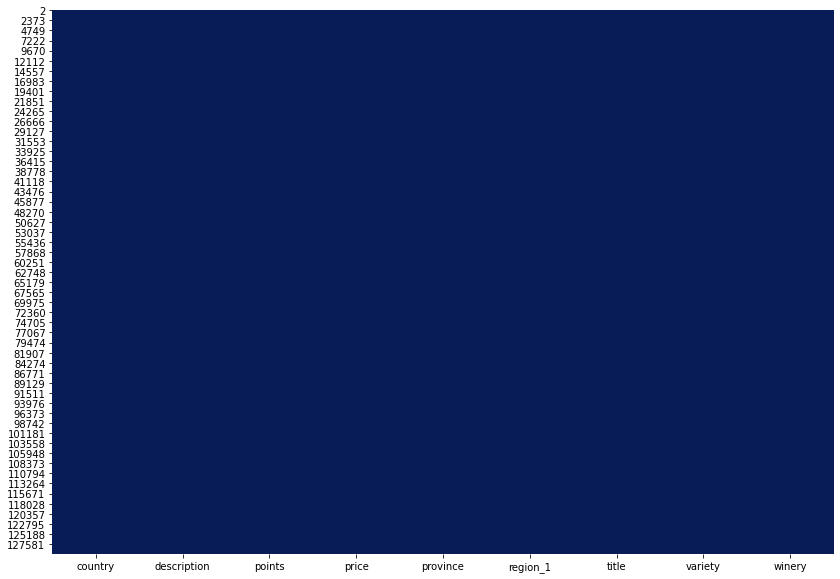

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101400 entries, 2 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      101400 non-null  object 
 1   description  101400 non-null  object 
 2   points       101400 non-null  int64  
 3   price        101400 non-null  float64
 4   province     101400 non-null  object 
 5   region_1     101400 non-null  object 
 6   title        101400 non-null  object 
 7   variety      101400 non-null  object 
 8   winery       101400 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 7.7+ MB


In [ ]:
len(df)

101400

## Графическое исследование данных

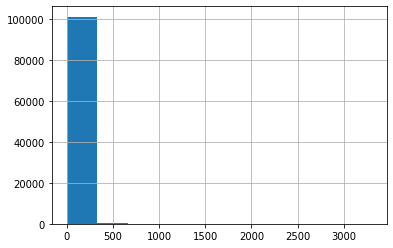

In [ ]:
df['price'].hist()

Давайте отфильтруем очень дорогие и посмотрим на обычный ценовой диапазон

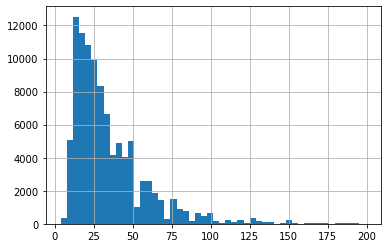

In [ ]:
df[df['price'] < 200]['price'].hist(bins = 50)

In [ ]:
# посмотрим на основную информацию
df['price'].describe()

count    101400.000000
mean         36.936558
std          41.895979
min           4.000000
25%          18.000000
50%          28.000000
75%          45.000000
max        3300.000000
Name: price, dtype: float64

Медиана ~28 за бутылку, средняя ~37, стандартное отклонение ~42 (в $)

In [ ]:
from matplotlib.pyplot import figure

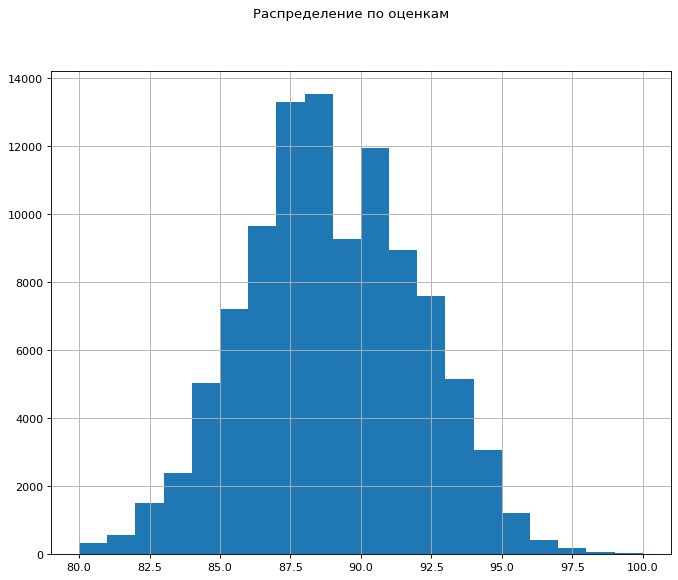

In [ ]:
import pylab as pl
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
pl.suptitle("Распределение по оценкам")
df['points'].hist(bins=20)

In [ ]:
df['points'].describe()

count    101400.000000
mean         88.463343
std           3.060467
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

Самая ценная информация хранится в текстовом обзоре, попробуем его предобработать "по старинке"

In [ ]:
import string
# реализуем предобработку
def preprocess(doc):
    # к нижнему регистру
    doc = doc.lower()
    # убираем пунктуацию, пробелы, прочее
    for p in string.punctuation + string.whitespace:
        doc = doc.replace(p, ' ')
    # убираем лишние пробелы, объединяем обратно
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

In [ ]:
# найдем все стобцы с типом данных строки
df.select_dtypes(include= np.object)

,country,description,province,region_1,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
...,...,...,...,...,...,...,...
129965,France,"While it's rich, this beautiful dry wine also ...",Alsace,Alsace,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann
129967,US,Citation is given as much as a decade of bottl...,Oregon,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Alsace,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",Alsace,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [ ]:
#  применим к этим столбцам нашу функцию понижения текста
for colname in df.select_dtypes(include= np.object).columns:
    df[colname] = df[colname].map(preprocess)
df.head()

,country,description,points,price,province,region_1,title,variety,winery
2,us,tart and snappy the flavors of lime flesh and ...,87,14.0,oregon,willamette valley,rainstorm 2013 pinot gris willamette valley,pinot gris,rainstorm
3,us,pineapple rind lemon pith and orange blossom s...,87,13.0,michigan,lake michigan shore,st julian 2013 reserve late harvest riesling l...,riesling,st julian
4,us,much like the regular bottling from 2012 this ...,87,65.0,oregon,willamette valley,sweet cheeks 2012 vintner s reserve wild child...,pinot noir,sweet cheeks
5,spain,blackberry and raspberry aromas show a typical...,87,15.0,northern spain,navarra,tandem 2011 ars in vitro tempranillo merlot na...,tempranillo merlot,tandem
6,italy,here s a bright informal red that opens with a...,87,16.0,sicily sardinia,vittoria,terre di giurfo 2013 belsito frappato vittoria,frappato,terre di giurfo


Что можно сделать с текстом? Преобразовать его в матрицу tfidf, которая каждому слову в тексте выставит его меру tfidf:

Каждому тексту (набору слов) ставит в соответствие вектор (набор цифр, по одной для каждого слова): text -> vector $v$ from $R^N$ where $N$ is a vocabulary size.

$TF-IDF(token, document) = TF(token, document) * IDF(token, document)$

$TF$ Частотность термина - кол-во встречаний в выбранном документе (в нашем случае описании):

$TF(token, document) = \frac{n_{token}}{\sum_{k}n_k}.$

$IDF$ обратная частота - логарифм от (количества документов) / (кол-во документов, где появлялось слово)

$IDF(token, all\_documents) = \log\frac{Total\ number\ of\ documents}{number\ of\ documents\ where\ token\ appeared}.$

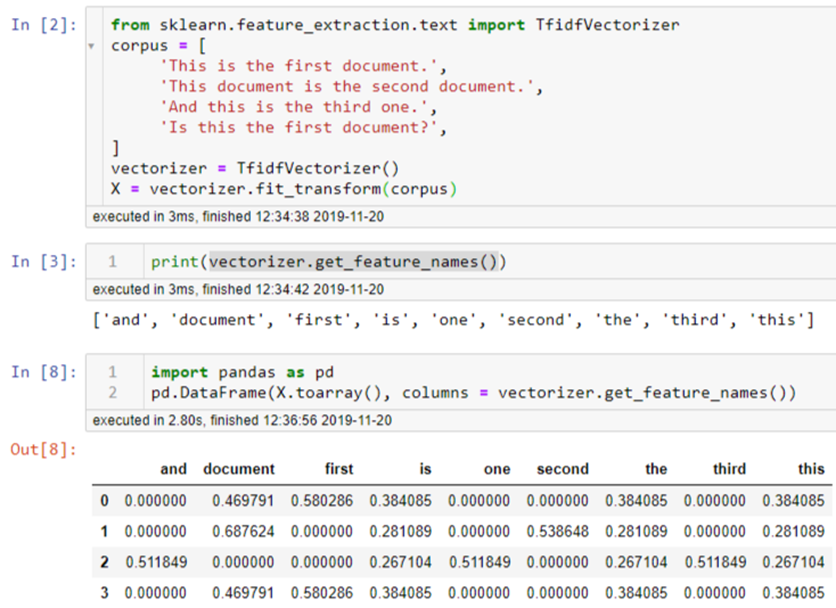

Для оперативности вычислений перемешаем обзоры и возьмем 10 тысяч из них:

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df = df[:10000]

In [ ]:
df.head()

,country,description,points,price,province,region_1,title,variety,winery
0,italy,this dark inky expression of sagrantino offers...,88,60.0,central italy,montefalco sagrantino,còlpetrone 2006 montefalco sagrantino,sagrantino,còlpetrone
1,italy,angimbé a 70 30 blend of insolia and chardonna...,85,14.0,sicily sardinia,sicilia,cusumano 2007 angimbé white sicilia,white blend,cusumano
2,spain,on the brink of excellence with a creamy more ...,88,24.0,galicia,rías baixas,terras gauda 2007 o rosal albariño rías baixas,albariño,terras gauda
3,france,there is lovely richness here with fresh acidi...,88,46.0,bordeaux,pomerol,château la bassonnerie 2007 pomerol,bordeaux style red blend,château la bassonnerie
4,us,kind of bizarre because there are baked custar...,82,18.0,california,el dorado,lava cap 2000 sémillon el dorado,sémillon,lava cap


In [ ]:
# импортируем tfidf преобразование
from sklearn.feature_extraction.text import TfidfVectorizer

# инициализировали алгоритм
vectorizer = TfidfVectorizer()
# преобразовали его в матрицу tfidf как в примере на картинке выше
X_np = vectorizer.fit_transform(df['description'].values)
# отобразили его размерность
print(X_np.shape)

(10000, 11476)


In [ ]:
# т.к. сам тип матрицы из scipy - преобразуем в tfidf
X_np = X_np.toarray()

Мы получили преобразованные описания в виде набор из 15263 столбцов, которые отвечают уникальным словам в этом описании. Сами слова можно найти через vectorizer.get_feature_names()

In [ ]:
# отобразим произвольные слова
print(vectorizer.get_feature_names()[3000:3010])

['detail', 'detailed', 'details', 'detect', 'detectable', 'determination', 'determined', 'detonates', 'detours', 'detract']


## Для начала решим задачу задачу без текстовых описаний

## Классификация

### Подготовка данных

Давайте для начала будем решать задачу кластеризации. Разделим наши оценки вина от 1 до 5, где 5 - максимальная, 1 - минимальная (исходя из колонки points)

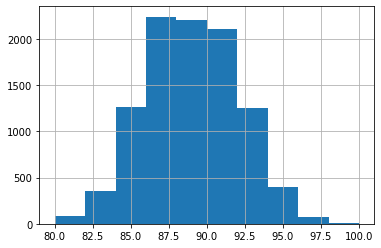

In [ ]:
df['points'].hist()

С учетом этого распределения оценки будут следующие
* 1: 80-85 - очень плохое вино
* 2: 85-88 - плохое вино
* 3: 88-92 - среднестатистическое вино
* 4: 92-95 - хорошее вино
* 5: 95-100 - очень хорошее

In [ ]:
def make_class(point):
    if point < 85:
        return 1
    elif point >= 85 and point < 88:
        return 2
    elif point >= 88 and point < 92:
        return 3
    elif point >= 92 and point < 95:
        return 4
    elif point >= 95:
        return 5

df['points'] = df['points'].apply(make_class)
df.head(10)

,country,description,points,price,province,region_1,title,variety,winery
0,italy,nebbiolo from two vineyard sites le coste and ...,3,82.0,piedmont,barolo,parusso 2008 le coste mosconi barolo,nebbiolo,parusso
1,us,this inaugural release is 88 cabernet sauvigno...,4,87.0,california,napa valley,les belles collines 2009 les sommets red napa ...,bordeaux style red blend,les belles collines
2,australia,faintly nutty notes of toasted grain accent th...,2,10.0,australia other,south eastern australia,kalbarri 2010 bin select 462 chardonnay south ...,chardonnay,kalbarri
3,italy,this light and refreshing sauvignon from north...,2,25.0,northeastern italy,collio,primosic 2008 gmajne sauvignon collio,sauvignon,primosic
4,us,an exuberantly ripe fruity cabernet brimming w...,2,25.0,california,lodi,mettler family vineyards 2006 estate cabernet ...,cabernet sauvignon,mettler family vineyards
5,france,while the wine is very sweet the sweetness doe...,4,78.0,alsace,alsace,domaine rieflé landmann 2012 seppi landmann zi...,gewürztraminer,domaine rieflé landmann
6,italy,aromas suggesting yellow spring flower beeswax...,3,16.0,northeastern italy,collio,gradis ciutta 2015 chardonnay collio,chardonnay,gradis ciutta
7,us,a bright fluffy white this moderately bodied o...,3,22.0,california,russian river valley,kenwood 2015 six ridges chardonnay russian riv...,chardonnay,kenwood
8,italy,here s a luminous and bright sweet sparkling w...,1,15.0,veneto,veneto,mionetto nv moscato dolce moscato veneto,moscato,mionetto
9,us,the smell of tart green apple frying in butter...,2,28.0,california,santa lucia highlands,morgan 2012 highland chardonnay santa lucia hi...,chardonnay,morgan


In [ ]:
df['points'].value_counts()

3    4321
2    2990
4    1542
1     950
5     197
Name: points, dtype: int64

In [ ]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

# используем все, кроме описания
encoded_data, encoders = number_encode_features(df.drop(columns='description')) # Теперь encoded data содержит закодированные кат. признаки 
encoded_data.head()

,country,points,price,province,region_1,title,variety,winery
0,4,3,82.0,40,47,6943,156,3709
1,6,4,87.0,8,461,5594,14,3042
2,1,2,10.0,3,639,5061,44,2795
3,4,2,25.0,32,173,7362,214,3925
4,6,2,25.0,8,361,6332,21,3398


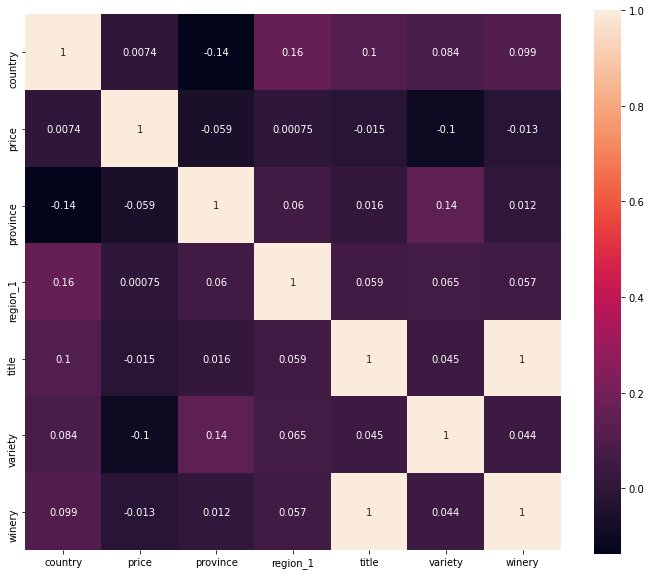

In [ ]:
plt.subplots(figsize=(12, 10))
sns.heatmap(encoded_data.corr(), square = True, annot=True)
plt.show()

In [ ]:
encoded_data.drop(columns=['winery'], inplace=True)
encoded_data.head()

,country,points,price,province,region_1,title,variety
0,4,3,82.0,40,47,6943,156
1,6,4,87.0,8,461,5594,14
2,1,2,10.0,3,639,5061,44
3,4,2,25.0,32,173,7362,214
4,6,2,25.0,8,361,6332,21


In [ ]:
# выделим целевую переменную - качество
y = np.array(encoded_data['points'])

In [ ]:
y

array([3, 4, 2, ..., 3, 1, 3])

In [ ]:
X = np.array(encoded_data.drop(columns=['points']), float)
X

array([[4.000e+00, 8.200e+01, 4.000e+01, 4.700e+01, 6.943e+03, 1.560e+02],
       [6.000e+00, 8.700e+01, 8.000e+00, 4.610e+02, 5.594e+03, 1.400e+01],
       [1.000e+00, 1.000e+01, 3.000e+00, 6.390e+02, 5.061e+03, 4.400e+01],
       ...,
       [6.000e+00, 6.500e+01, 8.000e+00, 4.610e+02, 9.322e+03, 1.950e+02],
       [3.000e+00, 3.200e+01, 0.000e+00, 9.000e+00, 3.214e+03, 2.000e+02],
       [6.000e+00, 4.500e+01, 3.700e+01, 7.610e+02, 9.695e+03, 1.850e+02]])

In [ ]:
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(X)*0.8)]

X_test = X[int(len(X)*0.8):]
y_test = y[int(len(X)*0.8):]

### Нормализация

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

In [ ]:
mean, std

(array([4.7815000e+00, 3.6714000e+01, 2.4145500e+01, 3.8454200e+02,
        4.9609085e+03, 1.4344675e+02]),
 array([1.59295566e+00, 3.57696024e+01, 1.87346625e+01, 2.32993677e+02,
        2.87097951e+03, 8.74678593e+01]))

In [ ]:
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 6) (2000, 6) (8000,) (2000,)


### Алгоритмы

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

### KNN

In [ ]:
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
knn_grid = {'n_neighbors': np.array(np.linspace(30, 50, 20), dtype='int')}
gs = GridSearchCV(knn, knn_grid)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'n_neighbors': 48}, 0.46825)

In [ ]:
# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='cross_val, accuracy'):
    # определили размер графика
    plt.figure(figsize=(12, 6))
    # добавили сетку на фон
    plt.grid(True)
    # построили по х - число соседей, по y - точность
    plt.plot(x, y, 'go-')
    # добавили подписи осей и название графика
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

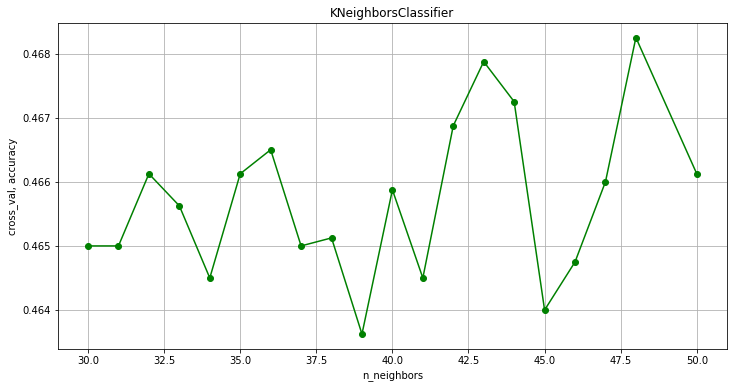

In [ ]:
# Строим график зависимости качества от числа соседей
# замечание: результаты обучения хранятся в атрибуте cv_results_ объекта gs
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=31, n_jobs=4)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=31, p=2,
                     weights='uniform')

In [ ]:
preds = knn.predict(X_test)

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.38      0.08      0.13       177
           2       0.49      0.46      0.47       600
           3       0.51      0.73      0.60       879
           4       0.46      0.22      0.29       297
           5       0.00      0.00      0.00        47

    accuracy                           0.49      2000
   macro avg       0.37      0.30      0.30      2000
weighted avg       0.47      0.49      0.46      2000



## SVM

Про параметр C:

Для лог. регрессии : https://habr.com/ru/company/ods/blog/323890/ (см пункт 3. Наглядный пример регуляризации логистической регрессии)

Для SVM: https://habr.com/ru/post/428503/

In [ ]:
alg = SVC()

grid = {'C': np.array(np.linspace(-5, 5, 10), dtype='float'),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished


({'C': 5.0, 'kernel': 'rbf'}, 0.48949999999999994)

In [ ]:
svm = SVC(C=5, kernel = 'rbf')

svm.fit(X_train, y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
preds = svm.predict(X_test)

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.36      0.02      0.04       177
           2       0.55      0.44      0.49       600
           3       0.52      0.84      0.64       879
           4       0.55      0.16      0.25       297
           5       0.56      0.19      0.29        47

    accuracy                           0.53      2000
   macro avg       0.51      0.33      0.34      2000
weighted avg       0.52      0.53      0.48      2000



## Логистическая

In [ ]:
alg = LogisticRegression()

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.logspace(-3, 2, num = 10), dtype='float')}

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.8s finished


({'C': 0.1668100537200059, 'penalty': 'l2'}, 0.49312500000000004)

In [ ]:
logreg = LogisticRegression(penalty='l2', C = 0.1668100537200059)

logreg.fit(X_train, y_train)

preds = logreg.predict(X_test)

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       177
           2       0.50      0.55      0.52       600
           3       0.53      0.71      0.61       879
           4       0.46      0.21      0.29       297
           5       0.30      0.06      0.11        47

    accuracy                           0.51      2000
   macro avg       0.36      0.31      0.31      2000
weighted avg       0.46      0.51      0.47      2000



## Регрессия

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {'penalty': ['l1', 'l2'],
        'alpha': [1e-4, 1e-5, 1e-6, 1e-7]}

reg = SGDRegressor()
gs = GridSearchCV(reg, grid, verbose = 2, scoring = 'r2')

# Обучаем его
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l2 ........................................
[CV] ......................... alpha=0.0001, penalty=l2, total=   0.0s
[CV] alpha=0.0001, penalty=l2 ........................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=1e-05, penalty=l1, total=   0.0s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV] .......................... alpha=1e-05, penalty=l2, total=   0.0s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV] .......................... alpha=1e-05, penalty=l2, total=   0.0s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV] .......................... alpha=1e-05, penalty=l2, total=   0.0s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV] .......................... alpha=1e-05, penalty=l2, total=   0.0s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV] .......................... alpha=1e-05, penalty=l2, total=   0.0s
[CV] alpha=1e-06, penalty=l1 .........................................
[CV] .......................... alpha=1e-06, penalty=l1, total=   0.0s
[CV] alpha=1e-06, penalty=l1 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


({'alpha': 0.0001, 'penalty': 'l2'}, 0.18754423547002824)

In [ ]:
reg = SGDRegressor(alpha = 1e-4, penalty='l2')
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

In [ ]:
print('R2 sgd (sklearn): ', r2_score(y_test, preds))

R2 sgd (sklearn):  0.12302806645343844


(array([  1.,   0.,   1.,   2.,   1.,   9., 195., 778., 901., 112.]),
 array([-8.8179025 , -7.69267585, -6.5674492 , -5.44222255, -4.3169959 ,
        -3.19176925, -2.0665426 , -0.94131595,  0.1839107 ,  1.30913734,
         2.43436399]),
 <a list of 10 Patch objects>)

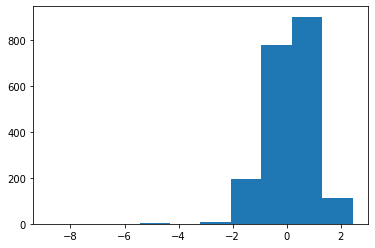

In [ ]:
plt.hist(y_test - preds)

In [ ]:

reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

In [ ]:
print('R2 gb: ', r2_score(y_test, preds))

R2 gb:  0.36938480415973196


(array([ 10.,  28., 128., 209., 481., 478., 471., 139.,  48.,   8.]),
 array([-2.50597434, -2.02944346, -1.55291258, -1.0763817 , -0.59985082,
        -0.12331994,  0.35321094,  0.82974182,  1.3062727 ,  1.78280358,
         2.25933446]),
 <a list of 10 Patch objects>)

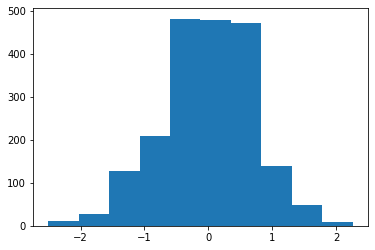

In [ ]:
plt.hist(y_test - preds)

(array([ 71., 144., 443., 519., 339., 329., 118.,  19.,  13.,   5.]),
 array([1.42022584, 1.76182309, 2.10342035, 2.44501761, 2.78661487,
        3.12821212, 3.46980938, 3.81140664, 4.15300389, 4.49460115,
        4.83619841]),
 <a list of 10 Patch objects>)

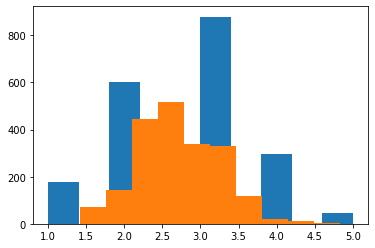

In [ ]:
plt.hist(y_test)
plt.hist(preds)

## Data+tfidf

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/winemag-data-130k-v2.csv', index_col='Unnamed: 0')

In [ ]:
df.drop(columns=['region_2', 'taster_name', 'taster_twitter_handle', 'designation'], inplace=True)
df.dropna(inplace=True)
df.head()

,country,description,points,price,province,region_1,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo


In [ ]:
df['points'] = df['points'].apply(make_class)
df.head(10)

NameError: ignored

In [ ]:
df.points.value_counts()

In [ ]:
#  применим к этим столбцам нашу функцию понижения текста
for colname in df.select_dtypes(include= np.object).columns:
    df[colname] = df[colname].map(preprocess)
df.head()

,country,description,points,price,province,region_1,title,variety,winery
2,us,tart and snappy the flavors of lime flesh and ...,2,14.0,oregon,willamette valley,rainstorm 2013 pinot gris willamette valley,pinot gris,rainstorm
3,us,pineapple rind lemon pith and orange blossom s...,2,13.0,michigan,lake michigan shore,st julian 2013 reserve late harvest riesling l...,riesling,st julian
4,us,much like the regular bottling from 2012 this ...,2,65.0,oregon,willamette valley,sweet cheeks 2012 vintner s reserve wild child...,pinot noir,sweet cheeks
5,spain,blackberry and raspberry aromas show a typical...,2,15.0,northern spain,navarra,tandem 2011 ars in vitro tempranillo merlot na...,tempranillo merlot,tandem
6,italy,here s a bright informal red that opens with a...,2,16.0,sicily sardinia,vittoria,terre di giurfo 2013 belsito frappato vittoria,frappato,terre di giurfo


In [ ]:
from sklearn import preprocessing

In [ ]:
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

In [ ]:
encoded_data, encoders = number_encode_features(df.drop(columns='description')) # Теперь encoded data содержит закодированные кат. признаки 
encoded_data.head()

,country,points,price,province,region_1,title,variety,winery
2,6,87,14.0,43,1192,69940,318,10741
3,6,87,13.0,30,538,78569,347,11860
4,6,87,65.0,43,1192,80105,322,12038
5,5,87,15.0,39,739,80765,430,12107
6,4,87,16.0,50,1179,82494,131,12369


In [ ]:
y = np.array(encoded_data.points)
del encoded_data['points']

In [ ]:
encoded_data

,country,price,province,region_1,title,variety,winery
2,6,14.0,43,1192,69940,318,10741
3,6,13.0,30,538,78569,347,11860
4,6,65.0,43,1192,80105,322,12038
5,5,15.0,39,739,80765,430,12107
6,4,16.0,50,1179,82494,131,12369
...,...,...,...,...,...,...,...
129965,3,28.0,0,21,29580,318,5187
129967,6,75.0,43,769,22789,322,4065
129968,3,30.0,0,21,28812,149,5037
129969,3,32.0,0,21,29266,318,5122


In [ ]:
y

array([87, 87, 87, ..., 90, 90, 90])

In [ ]:
encoded_data = encoded_data[:20000]

In [ ]:
y = y[:20000]

In [ ]:
X_train = encoded_data.values[:int(len(encoded_data.values)*0.8)]
y_train = y[:int(len(encoded_data.values)*0.8)]

X_test = encoded_data.values[int(len(encoded_data.values)*0.8):]
y_test = y[int(len(encoded_data.values)*0.8):]

In [ ]:
X_train.shape, y_train.shape

((16000, 7), (16000,))

In [ ]:
pd.Series(y_train).value_counts()

87     2193
88     1977
90     1878
86     1565
91     1374
89     1362
92     1263
85     1187
84      919
93      758
94      539
83      389
82      219
95      162
96       69
81       67
80       39
97       26
98       10
99        2
100       2
dtype: int64

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

In [ ]:
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
df['description']

2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
5         Blackberry and raspberry aromas show a typical...
6         Here's a bright, informal red that opens with ...
                                ...                        
129965    While it's rich, this beautiful dry wine also ...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 101400, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
# преобразовали его в матрицу tfidf как в примере на картинке выше
X_np = vectorizer.fit_transform(df['description'][:20000].values)
# отобразили его размерность
print(X_np.shape)

(20000, 15175)


In [ ]:
X_train.shape

(16000, 7)

In [ ]:
X_train = np.append(X_train, X_np.toarray()[:16000], axis=1)


In [ ]:
X_test = np.append(X_test, X_np.toarray()[16000:], axis=1)

In [ ]:
X_train.shape

(16000, 15182)

In [ ]:
X_test.shape

(4000, 15182)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
print('R2 gb: ', r2_score(y_test, preds))

R2 gb:  0.5639403067942397
